# Code for Calculating the Frobenius Norm of target unitary from different GRAPE functions

In this notebook, we use two different functions from the qutip control library ("optimize_pulse_unitary" from the pulseoptim object and "cy_grape_unitary" from the grape object), in order to implement the GRAPE algorithm. From this we obtain a final Unitary $\hat U$ which should be close to some given target Unitary $\hat U^*$. We then calculate the Frobenius norm squared of the difference between these two unitary as a measure of the error fidelity:

$$ || A  ||_{F}^2  = Tr(A^{\dagger}A) = \sum_{ij}^{N} |A_{ij}|^{2}$$


These values are then plotted against previously obtained results which obtained the unitary by reformulating the system in terms of a polynomial equation (https://arxiv.org/pdf/2209.05790.pdf) 

## Imports

Below are the necessary imports for running this code:

1) Qutip functions: 


The first line does import all qutip functions from the base object, which is used here to convery numpy arrays to Quantum objects using Qobj() and qeye() to create an identity operator of a specified size (here 3) as the initial starting point for the GRAPE algorithm.

The next set of imports are functions used for the pulseoptim class and a logger class which formats the result when being printed to terminal/ saving the to a file (I don't think we need them)

The final set of qutip imports are for implementing the cy_grape method. The TextProgressBar is justed used as a convenient way of tracking the progress of the function. (plot_grape_control_fields and _overlap are not necessary any more but are just used as tools for plotting the grape control fields and calculating the trace norm respectively)

2) Other imports:


The next set of imports are just the basic imports for simple tasks: 
matplotlib for plotting. 

numpy for storing and manipulating data.

h5py for reading and writing hdf5 files. 

time for time-keeping.  


In [1]:
from qutip import *

#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

from qutip.control import * 
from qutip.ui.progressbar import TextProgressBar
from qutip.control.grape import plot_grape_control_fields, _overlap


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import datetime
import h5py
import time 
start_time = time.time()

## Preparing the input data
 
 

 
In the cell below we read data from hdf5 files. The first is a list of 1000 3x3 target unitaries and the second is the frobenius norm calculated within the aforementioned paper. 

*Note: Bottom half of this cell may change as appending to an array can be computationally expensive* 

Sample here is used to denote the number of unitaries from the list that we would like to select and a for-loop is used to convert these unitaries into Qobj type which are stored in an array. Two empyt lists are also initialised which are used for storing data. (Note to self - Idea: I think I can remove the for-loop by calling the Qobj in the pulseoptim and cy_grap function parameters. The other appends maybe more difficult)



In [2]:
#Read in the hdf5 files
U_targetsFile = h5py.File("U_targets.hdf5", 'r')
norm_U_target_minus_obtainedFile = h5py.File("norm_U_target_minus_obtained.hdf5", 'r')

#extract the data and store in an array
U_targets = np.array(U_targetsFile["U_targets"])
norm_U_target_minus_obtained = np.array(norm_U_target_minus_obtainedFile["norm_U_target_minus_obtained"])


#Note to self:
#Find a way to do this using rel path to the Results folder 
#rather than copy paste the file to this directory
#Not import rn but do later


#tssos_glob_obj_minFile = h5py.File("tssos_glob_obj_min.hdf5", 'r')
#tssos_glob_obj_min = np.array(tssos_glob_obj_minFile["tssos_glob_obj_min"])



sample = 100 #U_targets.shape[2] #choose number of target unitaries
#choosing the first 100 unitaries for now


U_target_arr = [] #for storing unitaries as Qobj (* could be changed soon)

#for storing the obtained unitaries (*)
U_final_pulseoptim = []
U_final_cyGRAPE = []


# U_test = np.zeros((3,3,sample), dtype='complex') #just used to test something

for i in range(sample):
    U_target_arr.append(Qobj(U_targets[:,:,i])) #appending is not a good method for memory 
    

# display(U_test[:,:,0])
# display(U_target_arr[0])


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Choosing input parameters

The dynamics of the system are generated by the time dependent Hamiltionian:

$$H(t) = H_{0} + \sum_{i} u_i(t)H_{i} $$

Where $H_{0}$ is the drift Hamiltonian, $H_{i}$ are the control Hamiltonians and $u_{i}$ are the control fields. 

In the cell below we create Qobjs for $H_{0}$ and the single control $H_{c}$ according to the previously mentioned paper. We choose the Identity operator as the starting point for the GRAPE algorithm. We also can set the period over which the algorithm runs and the number of time slots at which act as the number of steps taken find a minimum in the landscape. 

(See https://qutip.org/docs/latest/guide/guide-control.html and the paper above for a more detail discussion).

In [3]:
H_drift_matrix = np.array([[0,0,0],
                           [0,0.515916, 0],
                           [0,0,1]])
H_control_matrix = np.array([[0,1/np.sqrt(2), 0],
                             [1/np.sqrt(2),0,0],
                             [0, 1, 0]])

H_drift = Qobj(H_drift_matrix)
H_control = [Qobj(H_control_matrix)] 
 
# Unitary starting point
U_0 = qeye(3)


# Number of time slots
n_ts = 100
# Time allowed for the evolution
evo_time = 1

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## pulseoptim

In the two cells below we run the function from the pulseoptim subclass. The first cell we select some more parameters for this function, these are:
 1) fid_error_tar - when this fidelity error is achieved we can terminate the algorithm as we have sufficiently achieved our goal.
 2) max_iterations - the max number of grape iterations (?? need to know more about this)
 3) max_wall_time - maximum time the algorithm runs before terminating if the target unitary has not been reached
 4) min_grad - minimum gradient to determine whether we are trapped in a local minima rather than a global minimia 
 5) p_type - the type of pusle for the control fields (here set to random)
 
 
 The second cell then runs the algorithm with these parameters for each unitary in the sample size. The finial unitary is stored in the "U_final_pulseoptim" list and for each iteration the termination reason and the fidelity error is printed out. You can also extract other useful information from the result variable such as the final control fields, the number of iterations used etc. 


In [4]:
#pulse optim extra params 

# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 100
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND' 

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
start_time_pulseoptim  = time.time() - start_time
for i in range(sample):
    result = cpo.optimize_pulse_unitary(H_drift, H_control, U_0, U_target_arr[i], n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                log_level=log_level,
                init_pulse_type=p_type, 
                gen_stats=True)
    print("Final fidelity error {}".format(result.fid_err))
    #print("Final fidelity {}".format(result.fidelity)) #?? this always gives 0.0 even though the fid_err is never 1.0
    # print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
   
    #Here all terminate due to convergence however if it terminates due to a different reason may cause a problem
    U_final_pulseoptim.append(result.evo_full_final)
    print(i)
    

#display(U_final_pulseoptim)
print("--- %s seconds to complete the pulseoptim method---" % (time.time() - start_time_pulseoptim))

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.    

Final fidelity error 0.003429940344132021
Terminated due to function converged
0


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003448173778097474
Terminated due to function converged
1


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002973614781003775
Terminated due to function converged
2


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031119966385712017
Terminated due to function converged
3


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036809481528436994
Terminated due to Iteration or fidelity function call limit reached
4


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003527276586418271
Terminated due to function converged
5


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031866825792610243
Terminated due to function converged
6


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003457063817891126
Terminated due to function converged
7


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003641175685584308
Terminated due to function converged
8


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033818692453831956
Terminated due to function converged
9


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035493159281905218
Terminated due to function converged
10


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003230861642068983
Terminated due to function converged
11


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033702528335446402
Terminated due to function converged
12


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003608377540085028
Terminated due to function converged
13


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:


Final fidelity error 0.005039155420052399
Terminated due to function converged
14


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00236943651379784
Terminated due to function converged
15


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031837171516051477
Terminated due to Iteration or fidelity function call limit reached
16


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019230020321017172
Terminated due to function converged
17


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020726619323715445
Terminated due to function converged
18


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033710424796000726
Terminated due to function converged
19


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:


Final fidelity error 0.0030984567821940034
Terminated due to function converged
20


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030068638826334926
Terminated due to function converged
21


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003561235517005601
Terminated due to function converged
22


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00332876529837578
Terminated due to function converged
23


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003523203751911397
Terminated due to function converged
24


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003370097186172427
Terminated due to function converged
25


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030797988322182057
Terminated due to function converged
26


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032776193516627083
Terminated due to function converged
27


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004942089827948082
Terminated due to function converged
28


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028942069131958625
Terminated due to function converged
29


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031901340669610034
Terminated due to function converged
30


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035511464155560946
Terminated due to function converged
31


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035232540558814973
Terminated due to function converged
32


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033099738891313457
Terminated due to function converged
33


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032242423295931744
Terminated due to function converged
34


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031671772845512924
Terminated due to function converged
35


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032989366110989238
Terminated due to function converged
36


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00324650320213693
Terminated due to function converged
37


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028179732510902333
Terminated due to function converged
38


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003492430895797094
Terminated due to function converged
39


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.009601337429153367
Terminated due to function converged
40


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024912791416962232
Terminated due to function converged
41


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.02072773681664264
Terminated due to function converged
42


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021814496290297747
Terminated due to function converged
43


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026772072741413355
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
44


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025618088145916706
Terminated due to function converged
45


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004741783404387356
Terminated due to function converged
46


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029373142141847497
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
47


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.018615172244996425
Terminated due to function converged
48


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003589765699860914
Terminated due to function converged
49


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003134373585675254
Terminated due to function converged
50


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030646417355481015
Terminated due to function converged
51


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034160819581813273
Terminated due to function converged
52


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033695440673403576
Terminated due to function converged
53


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021420602723760673
Terminated due to function converged
54


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024905763496138045
Terminated due to function converged
55


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003100743494854341
Terminated due to function converged
56


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003273820164503616
Terminated due to function converged
57


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002408127302228835
Terminated due to function converged
58


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003090429597299549
Terminated due to function converged
59


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022964335007710224
Terminated due to function converged
60


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032676802165870766
Terminated due to function converged
61


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034401661352014834
Terminated due to function converged
62


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003340055865263758
Terminated due to function converged
63


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002205293360880156
Terminated due to function converged
64


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035701824973071172
Terminated due to function converged
65


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033070962201838805
Terminated due to function converged
66


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029237717612088376
Terminated due to function converged
67


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030541635593371863
Terminated due to function converged
68


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.014742565657909767
Terminated due to function converged
69


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002979682102644432
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
70


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030672484029914404
Terminated due to function converged
71


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034295827465786743
Terminated due to function converged
72


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003519471851065825
Terminated due to function converged
73


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00349506037027858
Terminated due to function converged
74


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025675987378811493
Terminated due to function converged
75


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002731307121233595
Terminated due to function converged
76


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003290649730117612
Terminated due to function converged
77


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034259192079529877
Terminated due to function converged
78


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020711872394175268
Terminated due to function converged
79


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033342425232412154
Terminated due to function converged
80


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002008614288043109
Terminated due to function converged
81


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003657469407033931
Terminated due to function converged
82


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00888519728871151
Terminated due to function converged
83


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030724412498495113
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
84


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003510898130215212
Terminated due to function converged
85


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00337105926622705
Terminated due to function converged
86


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034719219319970795
Terminated due to function converged
87


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003615116997572776
Terminated due to function converged
88


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036052862939582875
Terminated due to function converged
89


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003478085388461394
Terminated due to function converged
90


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00305296439390923
Terminated due to function converged
91


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032504881090855697
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
92


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002023018146239952
Terminated due to function converged
93


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026720538958528994
Terminated due to function converged
94


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002881449697186733
Terminated due to function converged
95


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002877554651527392
Terminated due to function converged
96


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034930712732036406
Terminated due to function converged
97


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002912020541982918
Terminated due to function converged
98
Final fidelity error 0.003423153195977302
Terminated due to function converged
99
--- 1666342251.0167792 seconds to complete the pulseoptim method---


## cy_grape 

In these two cells below we set the the parameters and run the cy_grape_unitary function. There are less inputs in this method:

1) times - an array of where the number of elements = number of time slots and the final element is the period.
2) n_iterations - number of grape iterations

the second cell follows the same procedure as the cell above, however in this case we can track the progress of each iteration with TextProgressBar(). Here we only the store the final unitary, however one could extract other information from the result variable such as the final control fields (for each grape iteration). 


In [6]:
# cy_grape params
times = np.linspace(0,evo_time,n_ts)
n_iterations = 100

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
start_time_cy_grape = time.time() - start_time
for i in range(sample):
    #print(i)
    result = cy_grape_unitary(U_target_arr[i], H_drift, H_control, n_iterations, times, eps=2*np.pi/times[-1], phase_sensitive=False
                           ,progress_bar=TextProgressBar())
    U_final_cyGRAPE.append(result.U_f)
#display(U_final_cyGRAPE)


print("--- %s seconds to complete the cygrape method---" % (time.time() - start_time_cy_grape)) # don't think this is right lol

0


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10.0%. Run time:   3.41s. Est. time left: 00:00:00:30
20.0%. Run time:   6.98s. Est. time left: 00:00:00:27
30.0%. Run time:  10.36s. Est. time left: 00:00:00:24
40.0%. Run time:  13.61s. Est. time left: 00:00:00:20
50.0%. Run time:  16.92s. Est. time left: 00:00:00:16
60.0%. Run time:  20.21s. Est. time left: 00:00:00:13
70.0%. Run time:  23.81s. Est. time left: 00:00:00:10
80.0%. Run time:  27.28s. Est. time left: 00:00:00:06
90.0%. Run time:  30.53s. Est. time left: 00:00:00:03
Total run time:  33.49s
1
10.0%. Run time:   3.41s. Est. time left: 00:00:00:30
20.0%. Run time:   6.84s. Est. time left: 00:00:00:27
30.0%. Run time:  10.22s. Est. time left: 00:00:00:23
40.0%. Run time:  13.54s. Est. time left: 00:00:00:20
50.0%. Run time:  16.81s. Est. time left: 00:00:00:16
60.0%. Run time:  20.73s. Est. time left: 00:00:00:13
70.0%. Run time:  24.91s. Est. time left: 00:00:00:10
80.0%. Run time:  28.62s. Est. time left: 00:00:00:07
90.0%. Run time:  32.41s. Est. time left: 00:00:00:03
To

## Plotting Fidelity error (trace norm)
This code is for calculating the trace norm (overlap) of the obtained and target unitaries:
$$ \frac{1}{d} |Tr[\hat U^{\dagger}\hat U^{*}]| $$,

$d$ is the dimension of $\hat U$.

(currently not plotting this just calculating it. The cells for plotting have been commented out and folded as they still use TSSOS but will modify if needed)




In [10]:
#calculating fidelity

pulseoptim_fidelity = np.zeros(sample)
cy_grape_fidelity = np.zeros(sample)


for i in range(sample):
    pulseoptim_fidelity[i] = abs(_overlap(U_target_arr[i], U_final_pulseoptim[i]))
    cy_grape_fidelity[i] = abs(_overlap(U_target_arr[i], U_final_cyGRAPE[i]))
    


pulseoptim_fid_error = 1 - np.array(pulseoptim_fidelity) # would be better to directly get the error fidelity by doing result.fid_err in the loop as it is more accurate #but is pretty much the same
cy_grape_fid_error = 1 - np.array(cy_grape_fidelity)


#display(pulseoptim_fid_error)


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Plot for pulseoptim method


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'tssos_glob_obj_min' is not defined

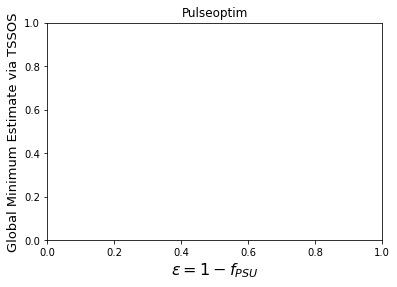

In [9]:
# plt.figure()
# plt.title('Pulseoptim')
# plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
# plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
# plt.plot(pulseoptim_fid_error, tssos_glob_obj_min, '.')
# plt.tight_layout()

## Plot for cy_grape method

In [ ]:
# plt.figure()
# plt.title('cy_grape')
# plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
# plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
# plt.plot(cy_grape_fid_error, tssos_glob_obj_min, '.')
# plt.tight_layout()

In [ ]:
plt.figure()
#plt.title('')
plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
plt.plot(pulseoptim_fid_error, tssos_glob_obj_min, '.', label='pulseoptim')
plt.plot(cy_grape_fid_error, tssos_glob_obj_min, '.', label='cy_grape')
plt.legend()
plt.tight_layout()

# Plotting Fidelity error  (Frobenius norm)

Here we use linalg from numpy to calculate the Frobenius norm squared for the difference between the obtained and target unitaries. 

(plots in this subsection have been commented out and folded becuase they still have tssos, could be deleted but ill just leave them here in case)

In [11]:
from numpy import linalg as LA

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#arrays for storing the data 
pulseoptim_fro_norm_squared =  np.zeros(sample)
cy_grape_fro_norm_squared =  np.zeros(sample)


for i in range(sample):
    #loop for caulating the fro norm squared for each unitary
    pulseoptim_fro_norm_squared[i] = LA.norm(U_final_pulseoptim[i] - U_target_arr[i], ord='fro')**2
    cy_grape_fro_norm_squared[i] = LA.norm(U_final_cyGRAPE[i] - U_target_arr[i], ord='fro' )**2

# display(pulseoptim_fro_norm_squared)
# display(cy_grape_fro_norm_squared)

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.2103639 , 0.21046933, 0.20772907, 0.20852688, 0.21188555,
       0.2109413 , 0.20894978, 0.21053264, 0.21159615, 0.21012545,
       0.21107343, 0.20920506, 0.21001095, 0.21140534, 0.21975459,
       0.20430025, 0.20905954, 0.2016916 , 0.31097791, 0.21001809,
       0.20844996, 0.20792384, 0.21115038, 0.20977978, 0.21091976,
       0.21000882, 0.20834293, 0.2094803 , 0.21929459, 0.2072831 ,
       0.20897485, 0.21106467, 0.21091154, 0.20967347, 0.20917791,
       0.20883955, 0.20964673, 0.20940484, 0.20683262, 0.21073443,
       0.24602387, 0.20495642, 0.31098435, 0.20320345, 0.20602368,
       0.20536266, 0.21817763, 0.20752205, 0.29812625, 0.2112994 ,
       0.20866469, 0.20825718, 0.21028425, 0.21001292, 0.20295526,
       0.20495776, 0.20845511, 0.20947325, 0.20451081, 0.20839612,
       0.20386808, 0.2094191 , 0.21043319, 0.20984528, 0.20332216,
       0.21118811, 0.20966232, 0.20744152, 0.20818822, 0.27564819,
       0.20776204, 0.2082878 , 0.21036442, 0.21087783, 0.21074

array([0.60576722, 0.81306561, 0.35784476, 0.69475011, 0.32215997,
       0.57959544, 0.82063323, 0.39935248, 0.70159969, 0.33221649,
       0.66300647, 0.7664111 , 1.182727  , 0.45465811, 0.31373988,
       0.89038219, 0.31630937, 0.34550308, 0.31225729, 1.08104891,
       0.44355074, 0.49016355, 0.42812401, 0.46945799, 0.45509865,
       0.58761027, 0.53563957, 1.00538418, 0.33115934, 0.32379757,
       1.08170339, 0.89939181, 0.55458074, 0.66596086, 0.45423514,
       0.70801561, 0.40353443, 0.31186049, 0.41738417, 0.985162  ,
       0.31403761, 0.32794809, 0.31188819, 0.42538   , 0.34398625,
       0.4405257 , 0.3124111 , 0.55141017, 0.34437087, 0.45210705,
       0.43646777, 0.54259708, 0.97430191, 0.33025538, 0.34105003,
       0.34140956, 0.53306738, 0.344404  , 0.31495175, 0.59449452,
       0.31274489, 0.52498835, 1.00513695, 0.45706427, 0.36020667,
       0.9251944 , 0.67864629, 0.33141484, 1.00229914, 0.32993821,
       0.44915896, 0.47154116, 0.73409978, 0.92489652, 0.75757

## pulseoptim plot

In [ ]:
# plt.figure()
# # plt.rc('text', usetex=False)
# plt.title('Pulseoptim')
# plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
# plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
# plt.plot(pulseoptim_fro_norm_squared, tssos_glob_obj_min, '.')
# plt.tight_layout()

## cy_grape plot

In [ ]:
# plt.figure()
# # plt.rc('text', usetex=False)
# plt.title('cy_grape')
# plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
# plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
# plt.plot(cy_grape_fro_norm_squared, tssos_glob_obj_min, '.')
# plt.tight_layout()

In [ ]:
# plt.figure()
# #plt.title('')
# plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
# plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
# plt.plot(pulseoptim_fro_norm_squared, tssos_glob_obj_min, '.', label='pulseoptim')
# plt.plot(cy_grape_fro_norm_squared, tssos_glob_obj_min, '.', label='cy_grape')
# plt.legend()
# plt.tight_layout()

## Plotting Frobenius norm from previous method vs GRAPE method

This is where we plot the previously obtained results from the polynomial reformulation (y-axis) against the frobenius squared norm we just calcualted above.

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


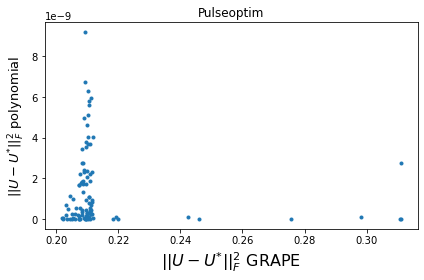

In [15]:
plt.figure()
plt.title('Pulseoptim')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.tight_layout()

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


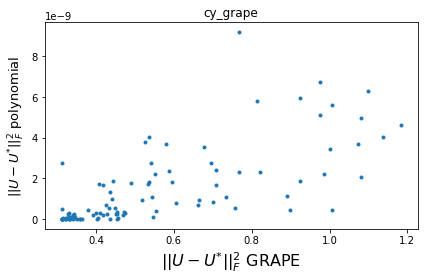

In [16]:
plt.figure()
plt.title('cy_grape')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(cy_grape_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.tight_layout()

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


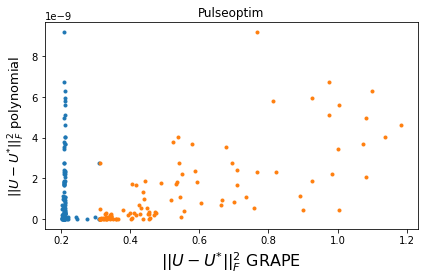

In [17]:
plt.figure()
plt.title('Pulseoptim')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.plot(cy_grape_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.tight_layout()

## Log Plots

Here we scale both y and x axis using the loglog function from matlibplot. The scaling chosen is $log_{10}$ as a default but you could also choose any base by adding parameters basex, basey and choosing a value.  

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


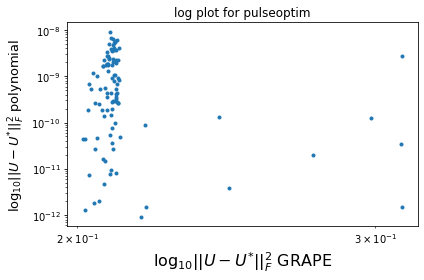

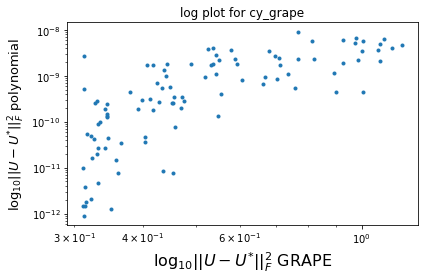

In [22]:
#pulseoptim

plt.figure()
plt.title('log plot for pulseoptim')
plt.xlabel(r'$\log_{10} ||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$\log_{10} ||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.loglog(pulseoptim_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.tight_layout()


#control grape

plt.figure()
plt.title('log plot for cy_grape')
plt.xlabel(r'$\log_{10} ||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$\log_{10} ||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.loglog(cy_grape_fro_norm_squared, norm_U_target_minus_obtained[:sample]**2, '.')
plt.tight_layout()

# Writing data to hdf5

In [ ]:
# with h5py.File('pulseoptim_fro_norm_squared.hdf5', 'w') as hf:
#     hf.create_dataset("pulseoptim_fro_norm_squared",  data=pulseoptim_fro_norm_squared)
    
# with h5py.File('cy_grape_fro_norm_squared.hdf5', 'w') as hf:
#     hf.create_dataset("cy_grape_fro_norm_squared",  data=cy_grape_fro_norm_squared)
    